In [167]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/Tomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Tomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df = pd.read_csv('data/wiki_movie_plots_deduped.csv')
df = df.drop(columns=['Director', 'Cast', 'Wiki Page'])
df.head(3)

,Release Year,Title,Origin/Ethnicity,Genre,Plot
0,1901,Kansas Saloon Smashers,American,unknown,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,unknown,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,unknown,"The film, just over a minute long, is composed..."


In [118]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r"[.,?!()\/#*&$^\-_:;'<>\[\]\"\\]", "", text)
    text = re.sub(r"(?<!\d)\d(?!\d)", "", text)
    text = text.lower()
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

In [160]:
n = 100
df_sample = df.head(n)


all_tokens = list(set(chain.from_iterable(df_sample['Plot'].apply(preprocess_text))))
all_tokens.sort()

In [161]:
dict = {word:0 for word in  all_tokens}

sample_entry = preprocess_text(df_sample.iloc[0]['Plot'])
sample_dct = Counter(sample_entry)
for word, count in sample_dct.items():
    dict[word] = count

In [162]:
X = np.zeros((n, len(all_tokens)))


for i, text in enumerate(df_sample['Plot']):
    word_dict = {word: 0 for word in all_tokens}
    sample_entry = preprocess_text(text)
    sample_dct = Counter(sample_entry)
    for word, count in sample_dct.items():
        word_dict[word] += count
    X[i] = list(word_dict.values())

In [163]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [166]:
pca = PCA()
pca.fit(X)




PCA()

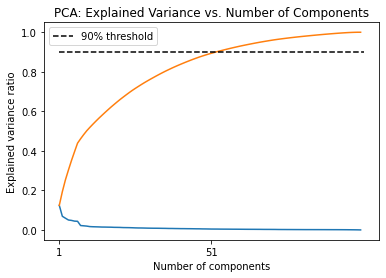

Number of components required to reach 90% explained variance: 53


In [168]:
threshold = 0.9

# Determine how many components are needed to reach the threshold
required_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) + 1

# Plot the accumulated explained variance ratio
fig = plt.figure()
plt.plot(range(1, pca.n_components_+1), pca.explained_variance_ratio_)
plt.plot(range(1, pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_))
plt.plot([1, 1+pca.n_components_], [threshold, threshold], "k--", label=f"{threshold:.0%} threshold")
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.xticks(range(1, pca.n_components_+1)[::50])
plt.legend()
plt.show()

### END SOLUTION
print(f"Number of components required to reach {threshold:.0%} explained variance: {required_components}")

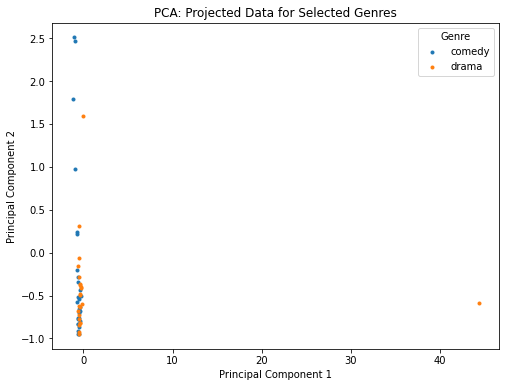

In [175]:

# Pick genres to visualize
genres = ['comedy', 'drama']

# Compute PCA projection if not already done
B = pca.transform(X)
# (or skip this if B is already computed)

plt.figure(figsize=(8, 6))

for genre in genres:
    mask = (df_sample['Genre'] == genre)
    plt.scatter(B[mask, 0], B[mask, 1], marker='.', label=genre)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: Projected Data for Selected Genres")
plt.legend(title="Genre")
plt.show()

In [172]:
df_sample['Genre'].value_counts()

comedy                        28
unknown                       27
drama                         23
western                        4
adventure                      2
horror                         2
drama, horror                  1
fantasy                        1
documentary drama              1
biographical drama             1
fantasy drama                  1
historical drama               1
silent sports                  1
crime                          1
short fantasy                  1
biographical                   1
short film                     1
short action/crime western     1
short                          1
adventure serial               1
Name: Genre, dtype: int64

In [173]:
len(df_sample)

100